In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

%matplotlib inline
dsb_data_dir = os.path.join('..', 'data/2018')
stage_label = 'stage1'
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
train_labels = pd.read_csv(os.path.join(dsb_data_dir, '{}_train_labels.csv'.format(stage_label)))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

,ImageId,EncodedPixels
17774,9774c82396327929fea05e40ae153cabf0107178b2ae3e...,"[5319, 3, 5574, 5, 5829, 7, 6085, 8, 6341, 8, ..."
25314,da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e751...,"[226620, 3, 227137, 11, 227655, 13, 228173, 15..."
12627,64eeef16fdc4e26523d27bfa71a1d38d2cb2e4fa116c0d...,"[7598, 5, 7853, 7, 8109, 8, 8365, 9, 8622, 9, ..."


In [3]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('/')[-3]
img_type = lambda in_path: in_path.split('/')[-2]
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)


,path,ImageId,ImageType,TrainingSplit,Stage
8945,../data/2018/stage1_train/76c4f14e35210f87a29e...,76c4f14e35210f87a29e93c46dbb25c8f5dc5c04d1d313...,masks,train,stage1
16949,../data/2018/stage1_train/c00ae67f72816daee468...,c00ae67f72816daee468474026e30705003b2d3501f123...,masks,train,stage1


In [4]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)
IMG_CHANNELS = 3


def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0) / 255.0


train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:, :, :IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

CPU times: user 28.4 s, sys: 4.45 s, total: 32.9 s
Wall time: 35.2 s


,Stage,ImageId,masks,images
86,stage1,1f6b7cead15344593b32d5f2345fc26713dc74d9b31306...,"[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[0.09019607843137255, 0.09019607843137255, 0..."


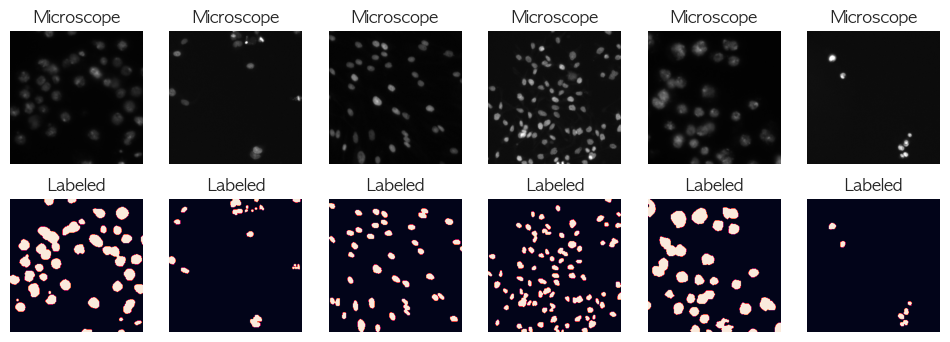

In [5]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize=(12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')

    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

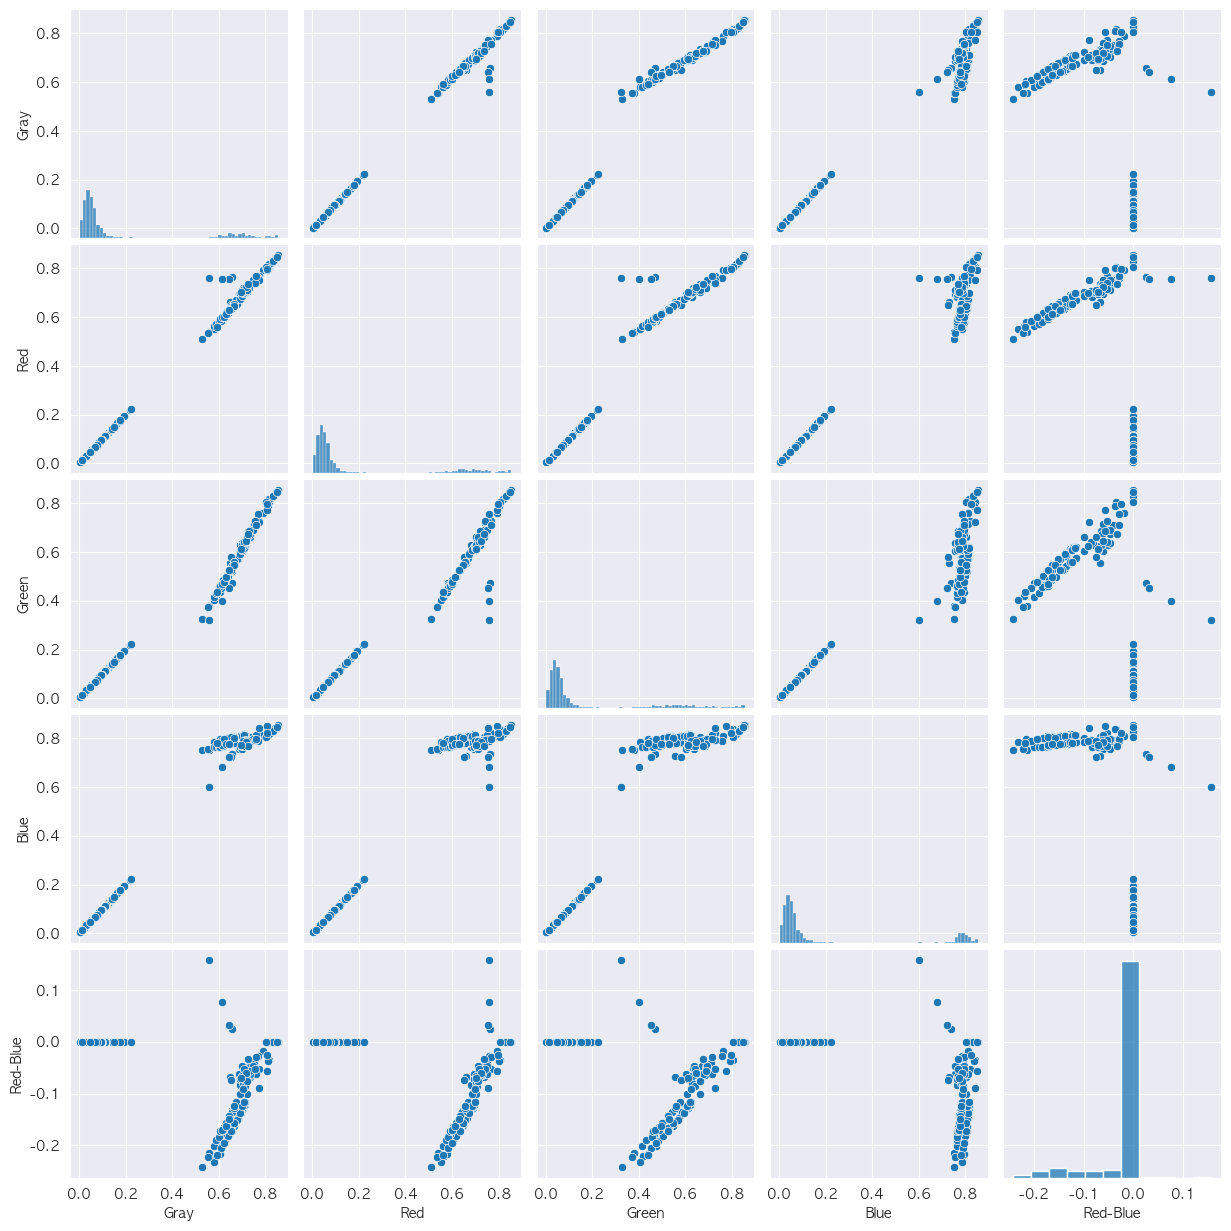

In [6]:
train_img_df['Red'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 0]))
train_img_df['Green'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 1]))
train_img_df['Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 2]))
train_img_df['Gray'] = train_img_df['images'].map(lambda x: np.mean(x))
train_img_df['Red-Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 0] - x[:, :, 2]))
sns.pairplot(train_img_df[['Gray', 'Red', 'Green', 'Blue', 'Red-Blue']])

In [7]:
train_img_df['images'].map(lambda x: x.shape).value_counts()

images
(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: count, dtype: int64

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda

simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape=(None, None, IMG_CHANNELS), name='NormalizeInput'))
simple_cnn.add(Conv2D(8, kernel_size=(3, 3), padding='same'))
simple_cnn.add(Conv2D(8, kernel_size=(3, 3), padding='same'))

simple_cnn.add(Conv2D(16, kernel_size=(3, 3), dilation_rate=2, padding='same'))
simple_cnn.add(Conv2D(16, kernel_size=(3, 3), dilation_rate=2, padding='same'))
simple_cnn.add(Conv2D(32, kernel_size=(3, 3), dilation_rate=3, padding='same'))

simple_cnn.add(Conv2D(16, kernel_size=(1, 1), padding='same'))
simple_cnn.add(Conv2D(1, kernel_size=(1, 1), padding='same', activation='sigmoid'))
simple_cnn.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ NormalizeInput                  │ (None, None, None, 3)  │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, None, None, 8)  │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None, 8)  │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, None, None, 16) │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, None, None, 16) │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, None, None, 32) │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, None, None, 16) │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, None, None, 1)  │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,493 (37.08 KB)

 Trainable params: 9,487 (37.06 KB)

 Non-trainable params: 6 (24.00 B)

In [9]:
from keras import backend as K

smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


simple_cnn.compile(optimizer='adam',
                   loss=dice_coef_loss,
                   metrics=[dice_coef, 'acc', 'mse'])

In [10]:
def simple_gen():
    while True:
        for _, c_row in train_img_df.iterrows():
            yield np.expand_dims(c_row['images'], 0), np.expand_dims(np.expand_dims(c_row['masks'], -1), 0)


simple_cnn.fit_generator(simple_gen(),
                         steps_per_epoch=train_img_df.shape[0],
                         epochs=3)

AttributeError: 'Sequential' object has no attribute 'fit_generator'

In [11]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:, :, :IMG_CHANNELS])
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

65 images to process
CPU times: user 435 ms, sys: 71.8 ms, total: 506 ms
Wall time: 580 ms


,Stage,ImageId,images
33,stage1,5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3ed...,"[[[0.0196078431372549, 0.0196078431372549, 0.0..."


In [12]:
%%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 

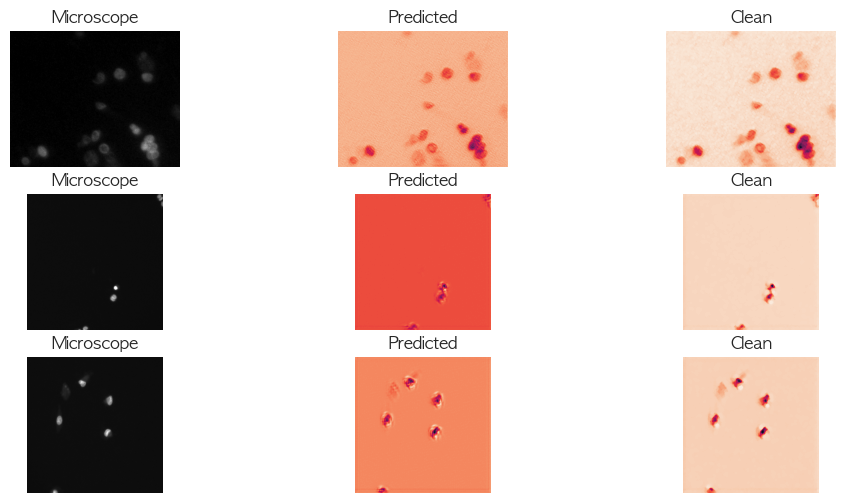

In [13]:
n_img = 3
from skimage.morphology import closing, opening, disk


def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))


fig, m_axs = plt.subplots(3, n_img, figsize=(12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(),
                                              m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')

    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')

    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')

In [14]:
from skimage.morphology import label


def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def prob_to_rles(x, cut_off=0.5):
    lab_img = label(x > cut_off)
    if lab_img.max() < 1:
        lab_img[0, 0] = 1
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [15]:
_, train_rle_row = next(train_img_df.tail(5).iterrows())
train_row_rles = list(prob_to_rles(train_rle_row['masks']))

In [16]:
tl_rles = train_labels.query('ImageId=="{ImageId}"'.format(**train_rle_row))['EncodedPixels']

In [17]:
match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key=lambda x: x[0]),
                              sorted(tl_rles, key=lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1
        else:
            mismatch += 1
print('Matches: %d, Mismatches: %d, Accuracy: %2.1f%%' % (match, mismatch, 100.0 * match / (match + mismatch)))

Matches: 360, Mismatches: 0, Accuracy: 100.0%


In [18]:
test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))

In [19]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list += [dict(ImageId=c_row['ImageId'],
                               EncodedPixels=' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

1658 regions found for 65 images


,ImageId,EncodedPixels
1657,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,20175 2 20178 1 20429 8 20685 8 20940 10 21197...
501,1cdbfee1951356e7b0a215073828695fe1ead5f8b1add1...,171320 2 171830 6 172342 6 172853 8 173366 7 1...
860,4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d...,46224 1 46478 8 46734 10 46989 12 47245 12 475...


In [20]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions.csv', index=False)